<a href="https://colab.research.google.com/github/Rosefinch-Midsummer/Awesome-Colab/blob/master/DS/House%20Price%20Regression%20with%20LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "naesaranderzhang" # username from the json file
os.environ['KAGGLE_KEY'] = "d580334ca87c88ae66a1995d318dca80" # key from the json file
#!kaggle datasets download -d iarunava/happy-house-dataset # api copied from kaggle
!kaggle competitions download -c house-prices-advanced-regression-techniques


  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 61.9MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 11.5MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 29.6MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 59.5MB/s]


In [2]:
import pandas as pd
df=pd.read_csv('train.csv')
df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,...,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,...,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [3]:
import pandas_profiling


pandas_profiling.ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,81
Number of observations,1460
Total Missing (%),5.9%
Total size in memory,924.0 KiB
Average record size in memory,648.1 B
Numeric,38
Categorical,43
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [4]:
df.isnull().any()

Id               False
MSSubClass       False
MSZoning         False
LotFrontage       True
LotArea          False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 81, dtype: bool

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

## House Price Regression with LightGBM

In [9]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Imputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import os
print(os.listdir("../content/"))

['.config', 'sample_submission.csv', 'train.csv', 'test.csv', 'data_description.txt', 'sample_data']


In [10]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

df_train.sample(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1365,1366,60,FV,NaN,7500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,533,Unf,0,281,814,GasA,...,Y,SBrkr,814,860,0,1674,1,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2000.0,RFn,2,663,TA,TA,Y,0,96,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,Normal,216000
939,940,70,RL,NaN,24090,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,2Story,7,7,1940,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Unf,0,Unf,0,1032,1032,GasA,...,Y,SBrkr,1207,1196,0,2403,0,0,2,0,4,1,TA,10,Typ,2,TA,Attchd,1940.0,Unf,1,349,TA,TA,Y,56,0,318,0,0,0,NaN,NaN,NaN,0,6,2010,COD,Normal,244400
401,402,20,RL,65.0,8767,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,24,Unf,0,1286,1310,GasA,...,Y,SBrkr,1310,0,0,1310,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Attchd,2005.0,Fin,2,400,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,New,Partial,164990


In [11]:
df_test.sample(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
775,2236,20,RL,79.0,11449,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,1011.0,Unf,0.0,873.0,1884.0,GasA,Ex,Y,SBrkr,1728,0,0,1728,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2007.0,Fin,2.0,520.0,TA,TA,Y,0,276,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal
1245,2706,20,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,RRAe,Norm,1Fam,1Story,5,6,1968,1968,Gable,CompShg,Plywood,Plywood,BrkFace,90.0,TA,TA,CBlock,TA,TA,No,BLQ,162.0,Rec,270.0,450.0,882.0,GasA,TA,Y,SBrkr,909,0,0,909,0.0,0.0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1968.0,Unf,1.0,294.0,TA,TA,Y,0,155,0,0,0,0,NaN,MnPrv,NaN,0,11,2006,COD,Normal
995,2456,50,RM,55.0,8674,Pave,NaN,Reg,HLS,AllPub,Inside,Gtl,BrkSide,RRNn,Artery,1Fam,1.5Fin,5,6,1950,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Fa,TA,No,Rec,910.0,Unf,0.0,0.0,910.0,GasA,TA,Y,SBrkr,910,525,0,1435,1.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1950.0,Unf,1.0,308.0,TA,TA,Y,0,33,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal


In [12]:
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

Shape train: (1460, 81), test: (1459, 80)


In [13]:
pd.options.display.max_columns = None # Show all cols
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [14]:
df_na = (df_train.isnull().sum() / len(df_train)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


### Target analysis
Target distribution is skewed and can be seen in the plots below - this is generally not a good thing. So we will need to adjust it so its normally distributed. This can be achieved with a log transform or something more powerful like box cox. On the diagram below, the left pane shows the original (skewed) data. The right pane show the transformed data.

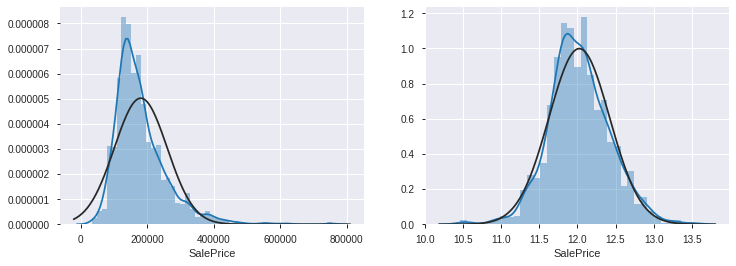

In [15]:
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(df_train['SalePrice'], ax=ax[0], fit=norm)
sns.distplot(np.log(df_train[('SalePrice')]+1), ax=ax[1], fit= norm)

## Data Engineering
We have to do some work to get the data into a format that will work with LightGBM. This covers:

- Handling categoricals
- Handling numericals
- Feature engineering - To generate new features

This would normally be packaged into some form of utility library as a separate step in the ML pipeline. In production setups this would typically be either Python or perhaps Spark for larger data sets.

In [0]:
def fill_missing(df, cols, val):
    """ Fill with the supplied val """
    for col in cols:
        df[col] = df[col].fillna(val)

def fill_missing_with_mode(df, cols):
    """ Fill with the mode """
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])
        
def addlogs(res, cols):
    """ Log transform feature list"""
    m = res.shape[1]
    for c in cols:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[c])).values)   
        res.columns.values[m] = c + '_log'
        m += 1
    return res

In [0]:
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

In [0]:
loglist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

df_train = addlogs(df_train, loglist)

In [0]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

In [0]:
fill_missing(df_train, ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 
                        "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                       "MasVnrType", "MSSubClass"], "None")
fill_missing(df_train, ["GarageYrBlt", "GarageArea", "GarageCars",
                       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                       "MasVnrArea"], 0)
fill_missing_with_mode(df_train, ["MSZoning", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType"])
fill_missing(df_train, ["Functional"],"Typ")
# Utils is pointless as there is only one row with a value
df_train.drop(['Utilities'], axis=1, inplace=True)
# For lot frontage we take the median of the neighbourhood. In general this would be a good approximation as most 
# house co located are similar in size 
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [0]:
df_train.drop(df_train[(df_train['OverallQual']<5) & (df_train['SalePrice']>200000)].index, inplace=True)
df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [0]:
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)

### Handle categoricals
First some util functions to dummy encode the categoricals. LightGBM can handle these natively but for now we do it manually as this could then easily be applied a pre process step for other algorithms.

In [0]:
def fix_missing_cols(in_train, in_test):
    missing_cols = set(in_train.columns) - set(in_test.columns)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        in_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    in_test = in_test[in_train.columns]
    return in_test

def dummy_encode(in_df_train, in_df_test):
    df_train = in_df_train
    df_test = in_df_test
    categorical_feats = [
        f for f in df_train.columns if df_train[f].dtype == 'object'
    ]
    print(categorical_feats)
    for f_ in categorical_feats:
        prefix = f_
        df_train = pd.concat([df_train, pd.get_dummies(df_train[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = pd.concat([df_test, pd.get_dummies(df_test[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = fix_missing_cols(df_train, df_test)
    return df_train, df_test

In [24]:
df_train, df_test = dummy_encode(df_train, df_test)
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
Shape train: (1456, 361), test: (1459, 361)


In [0]:
def load_poly_features(df_train, df_test, cols):
    """
    USeful function to generate poly terms
    :param df_train: The training data frame
    :param df_test: The test data frame
    :return: df_poly_features, df_poly_features_test - The training polynomial features + the test
    """
    print('Loading polynomial features..')
    # Make a new dataframe for polynomial features
    poly_features = df_train[cols]
    poly_features_test = df_test[cols]

    # imputer for handling missing values
    imputer = Imputer(strategy='median')

    # Need to impute missing values
    poly_features = imputer.fit_transform(poly_features)
    poly_features_test = imputer.transform(poly_features_test)

    # Create the polynomial object with specified degree
    poly_transformer = PolynomialFeatures(degree=3)
    # Train the polynomial features
    poly_transformer.fit(poly_features)

    # Transform the features
    poly_features = poly_transformer.transform(poly_features)
    poly_features_test = poly_transformer.transform(poly_features_test)
    print('Polynomial Features shape: %s' % str(poly_features.shape))

    df_poly_features = pd.DataFrame(poly_features,
                                    columns=poly_transformer.get_feature_names(cols))
    df_poly_features_test = pd.DataFrame(poly_features_test,
                                         columns=poly_transformer.get_feature_names(cols))
    df_poly_features['Id'] = df_train['Id']
    df_poly_features_test['Id'] = df_test['Id']
    print('Loaded polynomial features')
    return df_poly_features, df_poly_features_test

In [27]:
correlated_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']
df_train_poly, df_test_poly =  load_poly_features(df_train, df_test, cols=correlated_cols)
print("Shape train: %s, test: %s" % (df_train_poly.shape, df_test_poly.shape))

Loading polynomial features..
Polynomial Features shape: (1456, 84)
Loaded polynomial features
Shape train: (1456, 85), test: (1459, 85)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
df_train = df_train.merge(right=df_train_poly.reset_index(), how='left', on='Id')
df_test = df_test.merge(right=df_test_poly.reset_index(), how='left', on='Id')

In [29]:
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

Shape train: (1456, 446), test: (1459, 446)


###  Light GBM

Now lets run our regression!

First lets split up the data into our training data (X_train), our testing data frame (X_test) and our target variables that we want to predict for both training and testing (y_train and y_test respectively).

In [30]:
y = df_train["SalePrice"]
y.sample(3)

689     11.856522
1242    12.089544
242     11.277216
Name: SalePrice, dtype: float64

In [31]:
df_train.drop(["SalePrice"], axis=1, inplace=True)
# The fix missing cols above will have added the target column to the test data frame, so this is a workaround to remove it
df_test.drop(["SalePrice"], axis=1, inplace=True) 
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

Shape train: (1456, 445), test: (1459, 445)


In [0]:
X_train, X_test, y_train, y_test = train_test_split( df_train, y, test_size=0.2, random_state=42)

The hyper parameter settings are below. The settings below are best on a few iterations of training with some guided attempts driven by the documentation on the LightGBM website. They are far from the optimum..

In a real application we would adjust these to see the impact on loss - over numerous iterations. This would either be manual or more likely use a tool like Optunity or Hyperopt, to run automated hyper parameter tuning.

In [0]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

In [0]:
gbm = lgb.LGBMRegressor(**hyper_params)

In [35]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.157689	valid_0's auc: 1	valid_0's l1: 0.315676
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l2: 0.156429	valid_0's auc: 1	valid_0's l1: 0.314314
[3]	valid_0's l2: 0.155175	valid_0's auc: 1	valid_0's l1: 0.312948
[4]	valid_0's l2: 0.153904	valid_0's auc: 1	valid_0's l1: 0.311559
[5]	valid_0's l2: 0.152697	valid_0's auc: 1	valid_0's l1: 0.310226
[6]	valid_0's l2: 0.151548	valid_0's auc: 1	valid_0's l1: 0.308944
[7]	valid_0's l2: 0.15038	valid_0's auc: 1	valid_0's l1: 0.307653
[8]	valid_0's l2: 0.149113	valid_0's auc: 1	valid_0's l1: 0.30626
[9]	valid_0's l2: 0.147956	valid_0's auc: 1	valid_0's l1: 0.304964
[10]	valid_0's l2: 0.146818	valid_0's auc: 1	valid_0's l1: 0.30367
[11]	valid_0's l2: 0.145654	valid_0's auc: 1	valid_0's l1: 0.302354
[12]	valid_0's l2: 0.144493	valid_0's auc: 1	valid_0's l1: 0.30106
[13]	valid_0's l2: 0.143337	valid_0's auc: 1	valid_0's l1: 0.299747
[14]	valid_0's l2: 0.142158	valid_0's auc: 1	valid_0's l1: 0.2983

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.005, max_bin=512,
              max_depth=8, metric=['l2', 'auc'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=-1, num_iterations=100000, num_leaves=128,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, task='train',
              verbose=0)

In [0]:
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)

In [37]:
# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_log_error(y_pred, y_train) ** 0.5, 5))

The rmse of prediction is: 0.03021


In [0]:
test_pred = np.expm1(gbm.predict(df_test, num_iteration=gbm.best_iteration_))

In [0]:
df_test["SalePrice"] = test_pred
df_test.to_csv("results.csv", columns=["Id", "SalePrice"], index=False)

In [40]:
df_results=pd.read_csv('results.csv')
df_results.head()

,Id,SalePrice
0,1461,167171.855469
1,1462,167292.080814
2,1463,167486.979255
3,1464,167486.979255
4,1465,167536.935728


## Conclusion

LightGBM provides a robust implementation of gradient boosting for decision trees. The training times are comparably short and out of the box and with minimal tuning you can achieve excellent model accuracy. There is an good write up about LightGBM on Analytics Vidhya.

To take this model to the next level of performance, other areas to try would be:

- Different transformations to normalise the skewed data (eg Box Cox transform)
- Stacking or ensembling of multiple models together. Other possible models could be the SKlearn XGBOOST or something completely different like an ANN.
- Hyperparameter tuning should be applied. Currently only a few parameters have been tried. The parameter space is large for 
LightGBM with numerous possibilities. Something like Optunity would be able to automate finding a much better set, albeit taking some time to run.

With a few tweaks and some additional time on feature enrichment, then significant advances in accuracy could be achieved.